# Предсказание дефолта по кредиту

Многие люди берут кредит в банке. Некоторые не отдают. Если просрочка по кредиту больше 90 дней, банк считает, по данному кредиту произошел дефолт, то есть клиент не в состоянии его отдать.

Одна из первых задач, которую решало машинное обучение в банках, - предсказание дефолта.
Нужно по данным, которые предоставил потенциальный заемщик, определить, будет у него дефолт или нет.

Задача предсказания дефолта - задача классификации, а результат работы модели для конкретного клиента - предсказать произойдет дефолт или нет.
В этой тетради мы рассмотрим вопрос измерения качества работы обученных
классификаторов. На примерах мы опишем различные метрики качества и способы
их подсчёта. Также обратим внимание на адекватность их использования в типичных
практических кейсах.

Мы попробуем на данных из Kaggle соревнования _"Give me some credit"_ обучить модель машинного обучения, которая будет предсказывать дефолт.
https://www.kaggle.com/c/GiveMeSomeCredit#description

**Бизнес-постановка задачи**

Банк по анкетным данным оценивает вероятность того, что для конкретного клиента произойдет дефолт.
Применение модели ясно:
* мы хотим выдавать кредиты только хорошим заемщикам, которые отдадут кредит.

**Постановка задачи анализа данных**

Целью данной задачи является построение модели *классификации дефолтов*: на вход модель будет принимать данные о клиенте, а на выходе она должна работать в двух режимах:
* выдавать вероятность дефолта для данного клиента,
* выдавать правильный с точки зрения модели класс клиента (есть у него дефолт или нет).

Обучать модель мы будем по данным с платформы kaggle.

**Обзор доступных данных**

В выборке N наблюдений и 11 переменных, одна из которых - целевая.
Таким образом, про каждого из N клиентов мы знаем значения 11 их характеристик (возраст, доход в месяц), в том числе значение целевой переменной: есть ли у клиента сейчас просрочка более 90 дней.

Выборка была разбита на две части для обучения и для тестирования модели.

**Доступные признаки**

Данные содержат два типа переменных:

* Целевая: **SeriousDlqin2yrs**, есть ли просрочка 90 дней и более
* Остальные переменные: 10 переменных, могут использоваться для прогноза целевой переменной.

| Имя столбца        | Значение |
| :-------------: |:-------------:|
| SeriousDlqin2yrs      | **Целевая переменная:** Есть ли просрочка 90 дней и более |
| RevolvingUtilizationOfUnsecuredLines      | Доля использованных лимитов по кредитным картам     |
| age | Возраст заемщика в годах |
| DebtRatio | Отношение суммы долговой нагрузки, расходов на жизнь и алименты к доходу |
| MonthlyIncome | Доход в месяц |
| NumberOfOpenCreditLinesAndLoans | Количество открытых кредитов и кредитных линий (кредитных карт) |
| NumberRealEstateLoansOrLines | Количество ипотек и других кредитных продуктов, связанных с недвижимостью |
| NumberOfTime30-59DaysPastDueNotWorse | Сколько раз за последние 2 года у заемщика была просрочка 30-59 дней |
| NumberOfTime60-89DaysPastDueNotWorse | Сколько раз за последние 2 года у заемщика была просрочка 60-89 дней |
| NumberOfTimes90DaysLate | Сколько раз за последние 2 года у заемщика была просрочка более 90 дней |
| NumberOfDependents | Количество иждивенцев в семье (супруг, дети и т.п.) |



## План анализа данных (data mining):

  1. Загрузить данные для обучения
  2. Обработать данные перед обучением модели
  3. Обучить модель на обучающей выборке
  4. Загрузить и предобработать данные для тестирования
  5. Провалидировать модель на тестовой выборке

## 1. Загрузить данные для обучения

**Шаг 1.1. Загружаем библиотеки**

Для корректной работы с данными в python требуется загрузить специальную библиотеку
**pandas**, программную библиотеку на языке python для обработки и анализа данных.

Основная нагрузка по обработке входных данных ложится на модуль **pandas**. С
помощью функций `pandas.read_*` можно подтягивать данные из простых текстовых
файлов `CSV`, таблиц **Excel**, таблиц **HTML**, а также **SQL** запросами
из корпоративных баз данных и прочих распределённых хранилищ.

In [6]:
import pandas as pd

Для корректной работы с графиками в python требуется загрузить специальную библиотеку
**matplotlib**, программную библиотеку на языке python для визуализации данных двумерной и трехмерной графикой.

Графики используются для облегчения интерпретации полученных результатов, а также в качестве иллюстраций в презентациях и отчетах.

Оснвные методы для построения:
* plot() - графики
* semilogy() - график логарифметический
* hist() - гистограммы

In [7]:
import matplotlib.pyplot as plt # загружаем библиотеку и для простоты обращения в коде называем её сокращенно plt

Основную вычислительную нагрузку берёт на себя модуль **Numpy**, с помощью которого можно быстро производить
вычисления сразу над массивами чисел.

In [8]:
import numpy as np

Библиотека **scikit-learn** -- де факто наиболее популярный, разносторонний, хорошо
документированный и постоянно обогащающийся инструмент для построения моделей машинного
обучения.

Выберем из него:
* классификатор дерево решений (**DecisionTreeClassifier**);
* метод для удобной $k$*-fold* кросс-валидации (**KFold**);
* несколько готовых функции для расчёта метрик качества классификации.

In [9]:
from sklearn.tree import DecisionTreeClassifier # классификатор дерева решений

from sklearn.model_selection import KFold # k-folf кросс-валидация

from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score # метрики качества

Помимо задачи загрузки, расчётов и обучения моделей, немаловажную роль играет визуализация.
Она полезна как для предварительного анализа, так и для исследования метрик качеста, а также
упрощяет принятие решений и обобщение результатов.

Мы будем использовать библиотеку **MatplotLib**, которая отлично справляется с этой задачей.
Модуль **seaborn** устанавливет "приятные для глаз" палитры и стили для графиков.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid') # установить стиль whitegrid, другие стили можно найти в документации к seaborn

Некоторые библиотеки могут выводить на экран предупреждения, которые важно учитывать в "боевых" задачах. Но в учебной тетради мы укажем Python'у игнорировать их.

In [11]:
import warnings
warnings.filterwarnings("ignore")

<br/>

**Шаг 1.2. Загрузим данные**

Для решения задачи мы будем использовать данные. Они состоят из двух частей: часть для обучения и часть для тестирования модели. Загружаем данные с помощие команды !wget. Для того, чтобы игнорировать сообщения в процессе загрузки используем магическую команду %%capture в первой строке.

In [12]:
%%capture
!wget https://www.dropbox.com/s/io67uppgq66plbp/training_data.csv
!wget https://www.dropbox.com/s/2ga9maqxbsf8xhg/test_data.csv


Наши данные в формате `csv` - comma separated values, значения, разделенные точкой. Обычно data scientists работают с табличными данными, которые представлены именно в таком виде. Чтобы загрузить такие данные, будем использовать функцию **`pd.read_csv()`** из библиотеки `pandas`.

In [13]:
training_data = pd.read_csv('training_data.csv')


Посмотрим на 10 случайно выбранных записей из обучающего набора, для этого будем использовать функцию **sample()**. Параметр
**random_state=123** фиксирует "случайность", то есть на любом компьютере метод **sample()** будет работать одинаково.

In [14]:
# training_data.head(10)

training_data.sample(10)

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

**Шаг 1.3. Посмотрим общую статистику по данным**

Посмотрим на технические параметры загруженных данных для обучения. Для этого вызовем метод `describe()` для набора данных `training_data`

Для удобства отображения мы транспонируем результат: меняем местами столбцы и строки.

In [15]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,50000.0,0.066860,0.249782,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,50000.0,7.927880,332.393142,0.0,0.030096,0.154426,0.555651,50708.0
age,50000.0,52.240520,14.766593,21.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,50000.0,0.428220,4.269296,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,50000.0,352.441921,2006.426016,0.0,0.176304,0.366811,0.862599,329664.0
MonthlyIncome,40147.0,6642.232222,18122.708690,0.0,3400.000000,5400.000000,8250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,50000.0,8.476040,5.172756,0.0,5.000000,8.000000,11.000000,57.0
NumberOfTimes90DaysLate,50000.0,0.269920,4.243110,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,50000.0,1.017500,1.120151,0.0,0.000000,1.000000,2.000000,32.0
NumberOfTime60-89DaysPastDueNotWorse,50000.0,0.246040,4.231055,0.0,0.000000,0.000000,0.000000,98.0


Обратим внимание на общие статистики показателей в данных:
* **count** -- количество значений, которые не являются пропущенными (`NaN`);
* **mean**, **std** -- среднее и разброс данных в соответствующем поле;
* остальные статистики -- минимальное и максимальное значения, и квантили.

Из таких характеристик столбцов мы уже можем извлечь некоторую информацию о данных:
* У столбца **SeriousDlqin2yrs** среднее 0.060. Значит, в нашей выборке только у 6% клиентов есть дефолт.
* У столбца **MonthlyIncome** заполнено только 40147 из 50000. Минимальное значение дохода - 0, максимальное - 3008750.
* У столбца **NumberOfDependents** большое количество значений - нулевые.

## 2. Обработать данные перед обучением модели

**Шаг 2.1. Проверяем данные на наличие пропусков и типов переменных**

Начнем с проверки общей информации о данных.
Для того чтобы это сделать, нужно обратиться вызвать у переменной *training_data* метод **info()**.

Напомним, что info — метод, а значит необходимо поставить скобки.

In [16]:
# 1. TODO
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      50000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  50000 non-null  float64
 2   age                                   50000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  50000 non-null  int64  
 4   DebtRatio                             50000 non-null  float64
 5   MonthlyIncome                         40147 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       50000 non-null  int64  
 7   NumberOfTimes90DaysLate               50000 non-null  int64  
 8   NumberRealEstateLoansOrLines          50000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  50000 non-null  int64  
 10  NumberOfDependents                    48667 non-null  float64
dtypes: float64(4), 

Метод `info()` выводит информацию о таблице типа `pd.DataFrame`, включая формат `dtype` и `dtypes` столбца, ненулевые значения и использование памяти.

**Шаг 2.2. Заполнение пропусков**

Рассчитаем средние значения признаков в обучающей выборке, и заполним полученными
числами пропуски как в **тестовом наборе** данных, так и в **самой обучающей выборке**.

Мы будем заполнять средними значениями из обучающей выборки, так как при решении реальной задачи нам будут доступны только данные для обучения.

Для получения средних значений вызовем метод `mean()`. По умолчанию метод считает средним значения по столбцам. После выполнения ячейки средние значения записаны в переменной `train_mean`



In [17]:
# 2. TODO
train_mean = training_data.mean()

Пропуски в данных можно заполнять и разными методами:
* выборочной статистикой (среднее, медиана);
* прогнозами регрессии по известыми признакам;
* случайными значениями.

Если относительно небольшая доля наблюдению имеет пропуски, то можно
вовсе исключить неполные наблюдения с пропущенными значениями из выборки.

Для заполнения средним значеним, передадим на вход методу `fillna` полученный ранее набор средних значений для каждого столбца. Опция `inplace=True` говорит, что мы запишем изменения прямо в существующий массив, а не создадим новый.

In [18]:
training_data.fillna(train_mean, inplace=True)

**Шаг 2.3. Работаем с целевой переменной**

*Какая переменная целевая?*

В данном случае по условию задачи мы должны прогнозировать дефолт, поэтому целевая переменная - это наличие дефолта.

In [19]:
target_variable_name = 'SeriousDlqin2yrs'

Обратим внимание на целевой признак **SeriousDlqin2yrs** -- наличие серьёзной просрочки
по кредитным выплатам за последние два года. Обычно заёмщики стараются производить выплаты
вовремя.

Чтобы посчитать количество хороших заемщиков без больших просрочек (значение переменной **SeriousDlqin2yrs** равно нулю) и плохих с просрочкой (значение **SeriousDlqin2yrs** равно единице) вызовем метод `value_counts()`

In [20]:
training_data[target_variable_name].value_counts()

SeriousDlqin2yrs
0    46657
1     3343
Name: count, dtype: int64

Нам нужно выделить в отдельную переменную *training_values* столбец из нашей таблицы, который соответствует определенной выше целевой переменной. Для этого мы у таблицы *training_data* в квадратных скобках указываем имя нужного столбца. В нашем случае это имя записано в переменной *target_variable_name*.

In [21]:
# 4. TODO
training_values = training_data[target_variable_name]

Проверим размерность целевой переменной

In [22]:
training_values.shape

(50000,)

Запись `(50000,)` равносильна `(50000, 1)`.  Она означает, что у нас 50000 экземпляров в выборке и 1 признак

Отделим входные переменные от выходной (целевой), чтобы можно было построить модель предсказания целевой переменной по входным. Для это нужно у переменной training_data вызвать метод drop().

In [23]:
# 5. TODO
training_points = training_data.drop(target_variable_name, axis=1)

In [24]:
training_data.shape # (50000, 11)

(50000, 11)

In [25]:
training_points.shape # (50000, 10)

(50000, 10)

Видно, что столбца действительно нет, а количество строк не изменилось.

##   3. Обучить модель на обучающей выборке

**Шаг 3.1. Выбираем метод, который будем использовать**

Проще всего начать с простых методов.
Мы воспользуемся двумя методами для построения моделей классификации и сравним их между собой:
* Логистическая регрессия *logistic regression*
* Лес решающих деревьев *random forest*

Логистическая регрессия - "адаптация" линейной регрессии для решения задачи классификации. Она принадлежит к классу обобщенных линейных моделей.
А вот с помощью леса решающих деревьев можно хорошо решать и задачу регрессии, и задачу классификации.

Для корректной работы с методами построения моделей в python требуется загрузить специальную библиотеку
**sklearn**, программную библиотеку на языке python для для машинного обучения и анализа данных.

Мы импортируем два модуля из этой библиотеки:
 * *linear_model* - тут находятся все линейные *и обобщенные линейные* модели, в том числе модель логистической регрессии.
 * *ensemble* - тут находятся модели на основе ансамблей.

In [26]:
from sklearn import linear_model, ensemble


Чтобы создать модель логистической регресии, пишем имя модуля 'linear_model', затем точку, затем название модели.

Для этого нужно выполнить следующий код:

```python
logistic_regression_model = linear_model.logistic_regression_model()
logistic_regression_model
```

In [27]:
# 6. TODO
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_model

LogisticRegression()

Результат выполнения должен быть следующим:

```python
LogisticRegression(C=1.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None,
          penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
```

In [28]:
logistic_regression_model

LogisticRegression()

Модель логистической регрессии сложнее, чем модель линейной регрессии. Поэтому параметров у такой модели гораздо больше. Многие из них связаны с тем, с помощью какой процедуры мы будем подбирать параметры модели (*max_iter*, *dual*, *solver*, *tol*, *warm_start*), устойчивостью модели (*C*, *penalty*), тем, что мы решаем задачу классификации, а не регрессии (*class_weight*, *multi_class*)

Чтобы создать модель случайного леса, пишем имя модуля ensemble, затем точку, затем название модели.

Для этого нужно выполнить следующий код:

```python
random_forest_model = ensemble.RandomForestClassifier()
random_forest_model
```

Код отличается от кода при решении задачи регрессии тем, что теперь нам нужна модель для классификации `RandomForestClassifier`, а не регрессии `RandomForestRegressor`.
Результат выполнения должен быть следующим:
    
```python
RandomForestClassifier(bootstrap=True, class_weight=None,
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn',
            n_jobs=None, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
```

Создадим модель в переменной ```random_forest_model``` с параметром ```n_estimators=100```.

In [29]:
# 7. TODO
random_forest_model = ensemble.RandomForestClassifier(n_estimators=100)
random_forest_model

RandomForestClassifier()

In [30]:
random_forest_model

RandomForestClassifier()

У модели классификации на основе случайного леса больше параметров. Рассмотрим наиболее важные:
* параметр *n_estimators* определяет, сколько деревьев в лесу,
* в параметре *max_depth* устанавливается, какая максимальная глубина у дерева,
* в параметре *min_samples_leaf* задается, какое максимальное число объектов может попасть в лист дерева.

**Шаг 3.2. Обучить модель**

Теперь, когда мы создали прототипы обеих моделей, можем их обучить с помощью обучающей выборки.

Для этого вызываем метод **fit()** у каждой модели и передаем ему на вход два аргумента:
таблицу входных признаков и столбец значений целевой переменной - (training_points, training_values)

In [31]:
# 8. TODO
logistic_regression_model.fit(training_points, training_values)

LogisticRegression()

Делаем тоже самое для модели решающего леса.

Возможно, будут предупреждения, о том, что планируются изменения в будущем в этой модели (FutureWarning).

In [32]:
# 9. TODO
random_forest_model.fit(training_points, training_values)

RandomForestClassifier()

* Для двух разных моделей в sklearn методы для обучения модели не отличаются.
* Мы получили две обученные модели.
* Теперь необходимо провалидировать модели на новых тестовых данных, которые не использовались при обучении модели.

## 4. Загрузить и предобработать данные для тестирования

**Шаг 4.1. Загрузим данные для тестирования**

Наши данные в формате `csv` - comma separated values, значения, разделенные точкой. Обычно data scientists работают с табличными данными, которые представлены именно в таком виде. Чтобы загрузить такие данные, будем использовать функцию `pd.read_csv` из библиотеки `pandas`.

In [33]:
test_data = pd.read_csv('test_data.csv')

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      37500 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  37500 non-null  float64
 2   age                                   37500 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  37500 non-null  int64  
 4   DebtRatio                             37500 non-null  float64
 5   MonthlyIncome                         30044 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       37500 non-null  int64  
 7   NumberOfTimes90DaysLate               37500 non-null  int64  
 8   NumberRealEstateLoansOrLines          37500 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  37500 non-null  int64  
 10  NumberOfDependents                    36521 non-null  float64
dtypes: float64(4), 

In [35]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,37500.0,0.067387,0.250694,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,37500.0,6.031470,201.538421,0.0,0.029634,0.155112,0.565469,18300.0
age,37500.0,52.367387,14.769995,0.0,41.000000,52.000000,63.000000,107.0
NumberOfTime30-59DaysPastDueNotWorse,37500.0,0.448613,4.478678,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,37500.0,341.402289,1131.165077,0.0,0.173310,0.365951,0.866864,60212.0
MonthlyIncome,30044.0,6571.071295,7639.608316,0.0,3383.000000,5374.500000,8200.000000,562466.0
NumberOfOpenCreditLinesAndLoans,37500.0,8.428587,5.143302,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,37500.0,0.292667,4.458953,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,37500.0,1.020160,1.152043,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,37500.0,0.266160,4.444065,0.0,0.000000,0.000000,0.000000,98.0


**Шаг 4.2. Предобработка данных для тестирования**

Тестовые данные нужно предобработать аналогично обучающим. Поэтому заполним сперва пропуски в данных.

Для заполнения средним значеним, передадим на вход методу `fillna` полученный ранее набор средних значений для каждого столбца. Опция `inplace=True` говорит, что мы запишем изменения прямо в существующий массив, а не создадим новый

In [36]:
# 10. TODO
test_data.fillna(train_mean, inplace=True)
# test_data.

**Шаг 4.3. Отделяем целевую переменную**

Нам нужно выделить в отдельную переменную *test_values* столбец из нашей таблицы, который соответствует определенной выше целевой переменной. Для этого мы у таблицы *test_data* в квадратных скобках указываем имя нужного столбца. В нашем случае это имя записано в переменной *target_variable_name*.

In [37]:
# 11. TODO
test_values = test_data[target_variable_name]

In [38]:
# 12. TODO
test_points = test_data.drop(target_variable_name, axis=1)

И проверяем результат записанный в test_points

In [39]:
test_points.shape # (37500, 10)

(37500, 10)

# 5. Провалидировать модель на тестовой выборке

Сначала получим прогноз модели на тестовых данных *`test_points`* с помощью моделей логистической регрессии и решающего леса.
Для этого для обеих моделей запустим метод **`predict()`**.

In [40]:
# 13. TODO
test_predictions_logistic_regression = logistic_regression_model.predict(test_points)

In [41]:
# 14. TODO
test_predictions_random_forest = random_forest_model.predict(test_points)

Посмотрим, сколько предсказаний каждого вида (дефолтов и возвратов кредитов) спрогнозировали модели. Для этого необходимо вызвать функцию **`value_counts()`** из библиотеки **`pandas`** для полученных прогнозов.

In [42]:
# 15. TODO
pd.Series(test_predictions_logistic_regression).value_counts()

0    37436
1       64
Name: count, dtype: int64

Модель логистической регрессии предсказывает X неуплат и Y возвратов кредита в срок.  

In [43]:
# 16. TODO
pd.Series(test_predictions_random_forest).value_counts()

0    36615
1      885
Name: count, dtype: int64

Модель случайного леса предсказывает X' случаев неуплаты и Y' возврата кредита в срок.  

### Шаг 5.1. Точность прогноза

Естественный способ измерить качество модели - посчитать долю правильных предсказаний, то есть, сколько в процентном соотношении от размера тестовой выборки модель угадала единичек и сколько угадала ноликов. Такая метрика называется точность (accuracy).

Функция для подсчета точности реализована в библиотеке **sklearn** и называется **`accuracy_score()`**. Импортируем её.

In [44]:
from sklearn.metrics import accuracy_score

В функцию **`accuracy_score()`** необходимо передать два аргумента:
* истинные значения меток - *test_values*
* предсказания модели - *test_predictions_logistic_regression* или *test_predictions_random_forest*

In [45]:
# 17. TODO
accuracy_score(test_values, test_predictions_logistic_regression)

0.9324533333333334

**Как понять, хорошо работает модель или нет?**

Из значения точности мы никак не можем понять, сколько меток каждого класса правильно предсказала модель. В нашей задаче мало значений с классом 1 (дефолт), но много 0 (возврат кредита). Может быть такая ситуация, когда модель очень хорошо научилась выделять характеристики большого класса, в нашем случае 0, но совсем не умеет выделять характеристики маленького класса. А часто именно последние в большей степени интересуют аналитиков.

Самый простой способ проверить - это сравнить значения точности для наших моделей с точностью для константного классификатора, модели, которая всегда бы предсказывала больший класс, в нашем случае 0.
Для этого можно в функцию **`accuracy_score()`** в качестве второго аргумента передать массив нулей такого же размера, как и *test_values*. Это делается с помощью функции **`zeros_like()`** из библиотеки numpy, у которой один аргумент - *test_values*, массив с размером которого будет создан массив нулей.

In [46]:
# 18. TODO
accuracy_score(test_values, np.zeros_like(test_values))

0.9326133333333333

Действительно, для логистической регрессии точность очень близка к точности константного классификатора. Это не означает, что логистическая регрессия работает определенно плохо, но необходимо проверить дополнительные метрики.

### Шаг 5.2. Таблица сопряженности модели классификации

Другой способ оценивать качество работы классификатора - использовать таблицу сопряженности.

**Таблица сопряжённости** (матрица неточности, или Confusion matrix) содержит сводные показатели качества работы классификатора. **Строки** этой таблицы соответствуют **фактическим классам** тестового набора, а **столбцы** - **предсказанным** классификатором меткам.

Импортируем функцию для построения таблицы сопряженности из библиотеки **`sklearn`**.

In [47]:
from sklearn.metrics import confusion_matrix

Таблица содержит четыре сводных показателя, каждый из которых отражает количество объектов в одной и четырех
категорий:
* **истинно позитивный** (*True positive*, **TP**) -- объект
класса `1` был верно помечен меткой `1`;
* **ложно позитивный** (*False positive*, **FP**) -- объект
фактически принадлежит классу `0`, но помечен меткой `1`;
* **истинно отрицательный** (*True negative*, **TN**) -- классификатор
верно определил, что объект класса `0` принадлежит классу `0`;
* **ложно отрицательный** (*False negative*, **FN**) -- классификатор
пометил объект меткой `0`, однако на самом деле объект принадлежит классу `1`.


Замечание: ошибки False positive часто называют **ложной тревогой**, а False negative - **пропуском цели**.

|                   |  Предсказано `0` |  Предсказано `1` |
|:-------------------|:------------------|:------------------|
|**Фактически** `0`  |       TN         |       FP         |
|**Фактически** `1`  |       FN         |       TP         |

Посмотрим на таблицу сопряженности для логистической регрессии и случайного леса. Для этого в функцию **`confusion_matrix()`** необходимо передать два аргумента:
* истинные значения меток - *test_values*
* предсказания модели - *test_predictions_random_forest* и аналогично для второй модели — *test_predictions_logistic_regression*

Далее для удобства мы запишем полученную матрицу в удобный табличный вид, воспользовавшись функцией **`DataFrame()`** из библиотеки **pandas**.

In [48]:
# 19. TODO

logistic_regression_confusion_matrix = confusion_matrix(test_values, test_predictions_logistic_regression)
logistic_regression_confusion_matrix = pd.DataFrame(logistic_regression_confusion_matrix)

logistic_regression_confusion_matrix

,0,1
0,34938,35
1,2498,29


In [49]:
# 20. TODO

random_forest_confusion_matrix = confusion_matrix(test_values, test_predictions_random_forest)
random_forest_confusion_matrix = pd.DataFrame(random_forest_confusion_matrix)

random_forest_confusion_matrix

,0,1
0,34557,416
1,2058,469


Разберем полученные значения подробнее:

Почему значения на картинке могут отличаются от тех, которые мы получили?

`random_seed` не был зафиксирован в модели Случайных лесов, и мы видим незначительные отклонения в результатах предсказания.

### Шаг 5.3. Прогноз вероятности принадлежности к классу

Вместо прогноза меток классов модель может с помощью метода **`predict_proba()`** выдавать метки вероятности принадлежности к классам.
Так как класса у нас 2: заемщики с дефолтом и без, то матрица будет размером **(количество объектов в тестовой выборке, 2)**.

In [50]:
test_probabilities = logistic_regression_model.predict_proba(test_points)

Посмотрим на первые пять значений этой матрицу:

In [51]:
test_probabilities[:5, :]

array([[0.82114938, 0.17885062],
       [0.83650029, 0.16349971],
       [0.94724045, 0.05275955],
       [0.88776946, 0.11223054],
       [0.92406637, 0.07593363]])

Вероятность принадлежности ко второму классу - во втором столбце матрицы вероятностей.

In [52]:
test_probabilities = test_probabilities[:, 1]

Посмотрим на распределение предсказанной классификатором вероятности дефолта, метки `1`.

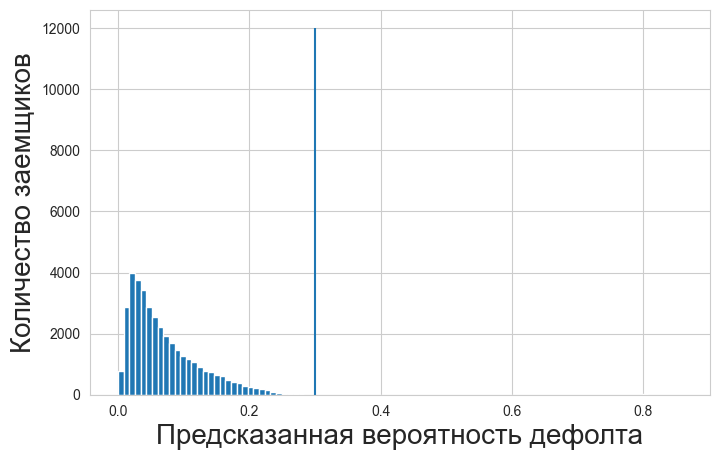

In [53]:
plt.figure(figsize=(8, 5))

plt.hist(test_probabilities, bins=100)
plt.vlines(0.3, 0, 12000)

plt.xlabel('Предсказанная вероятность дефолта', fontsize=20)
plt.ylabel('Количество заемщиков', fontsize=20);

Распределение сконцентрировано на отрезке от `0` до `0.3` и лишь незначительная часть вероятностей превышает порог `0.5`. Из
этого можно предположить, что классификатор склонен классифицировать все
объекты скорее как `0`, игнорируя метку `1`. Это происходит потому, что меток `1` в обучающей выборке сильно меньше, чем меток `0`.

### Шаг 5.4. Выбор порога классификатора

На самом деле, при вызове метода **`predict()`** классификатор преобразует полученные вероятности в метки. По умолчанию для этого используется сравнение с порогом $0.5$: если вероятность объекта меньше порога, то этот объект относится к классу 0, если больше - к классу 1.  

По умолчанию классификатор использует порог $0.5$, чтобы из вероятностей принадлежности к классу сделать метки классов.  

**За что отвечает порог классификатора?**

Порог классификатора контролирует соотношение между количеством False positive и False negative. Если мы задаем слишком высокий порог классификатора, то он редко предсказывает 1, но часто 0, таким образом, увеличивается количество False negative и уменьшается количество False positive. Если же порог низкий - мы часто предсказываем 1, а 0 реже, значит увеличивается количество False positive и уменьшается False negative.

Что это значит в нашей задаче кредитного скоринга? Если порог высокий, то мы реже считаем клиентов подозрительными и чаще выдаем клиентам кредит. В этом случае банк может потерять много денег из-за невозвратов. Если же порог низкий, то мы чаще считаем клиентов подозрительными и выдаем мало кредитов. Очевидно, это тоже плохо, так как мы часто не выдаем кредиты честным клиентам, что отражается на прибыли банка.

Посмотрим на то, как влияет порог на матрицу сопряженности.  

In [54]:
higher_thershold = 0.7
alternative_test_predictions = test_probabilities > higher_thershold


In [55]:
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
alternative_confusion_matrix

,0,1
0,34947,26
1,2508,19


Действительно, количество ложно-отрицательных (False negative) срабатываний увеличилось, а количество ложно-положительных срабатываний (False positive) уменьшилось.

**Задание:** получите confusion matrix для уменьшенного значения порога 0.3

In [56]:
# 21. TODO
lower_thershold = 0.3
alternative_test_predictions = test_probabilities > lower_thershold
alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
alternative_confusion_matrix

,0,1
0,34925,48
1,2483,44


In [57]:
# 22. TODO
thresholds = [0.3, 0.5, 0.7]
for threshold in thresholds:
    test_probabilities_rf = random_forest_model.predict_proba(test_points)[:, 1]
    alternative_test_predictions = test_probabilities_rf > threshold # Применяем порог
    alternative_confusion_matrix = pd.DataFrame(confusion_matrix(test_values, alternative_test_predictions))
    print(f"Confusion Matrix for Threshold {threshold}:\n")
    print(alternative_confusion_matrix)
    print("\n")
# Получите confusion matrix для порогов: 0.3, 0.5, 0.7 для алгоритма Random Forest и выведите её.

Confusion Matrix for Threshold 0.3:

       0     1
0  33584  1389
1   1531   996


Confusion Matrix for Threshold 0.5:

       0    1
0  34557  416
1   2058  469


Confusion Matrix for Threshold 0.7:

       0    1
0  34907   66
1   2412  115




### *Бонус:  ROC кривая классификатора

Если хотят сравнить метрики на разных наборах данных, обычно работают не с абсолютными значениями True Positive и False Positive, а с их долями:

* Доля ложноположительных срабатываний $\text{FPR} = \frac{FP}{FP + TN}$;
* Доля истинно положительных срабатываний $\text{TPR} = \frac{TP}{TP + FN}$.

Заметим, что $FP + TN$ дает общее число объектов класса $0$, а $TP + FN$ - общее число объектов класса $1$.

Одной из самых популярных метрик для задачи классификации является ROC кривая. ROC расшифровывается как *Receiver Operating Characteristic*. Эта кривая наглядно показывает зависимость доли истинно позитивных срабатываний (**TPR**) от доли ложно позитивных срабатываний (**FPR**) при изменении порога классификации.

Функция **roc_curve()** из **scikit-learn** позволяет получить координаты точек ROC кривой, а также значения порога **threshold**, при котором достигается соответствующие значения метрик **FPR** и **TPR**.

На вход функции **roc_curve()** необходимо передать два аргумента:
* истинные значения меток - *test_values*
* вероятности, предсказанные моделью - *test_probabilities*

In [58]:
# 23. TODO

false_positive_rates, true_positive_rates, threshold = roc_curve(test_values, test_probabilities)

Нарисуем кривую

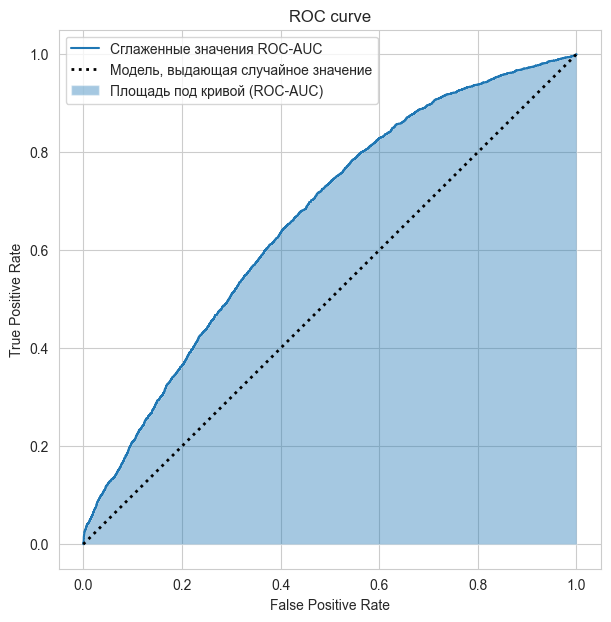

In [59]:
# создаём график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='Площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

Чем ближе в целом кривая **ROC** к **левому верхнему** углу, тем лучше качество классификации.

Несмотря на наглядность, иногда требуется некоторое число, обобщающее весь
график. Для ROC кривой таким числом является "площадь под кривой" (**ROC-AUC**).

В **sklearn** есть специальная функция **roc_auc_score()** для подсчёта
площади под ROC-кривой.

In [60]:
from sklearn.metrics import roc_auc_score

Типичная шкала для **ROC-AUC** (часто все зависит от задачи):
* $0.90$ - $1.00$ отлично;
* $0.80$ - $0.90$ хорошо;
* $0.70$ - $0.80$ удовлетворительно;
* $0.60$ - $0.70$ плохо;
* $0.50$ - $0.60$ очень плохо;
* $0.00$ - $0.50$ классификатор перепутал метки.

Вычислите значения *roc_auc_value* для обеих моделей

In [61]:
# 24. TODO
test_probabilities = logistic_regression_model.predict_proba(test_points)
roc_auc_value = roc_auc_score(test_values, test_probabilities[:, 1])

print("ROC-AUC на тестовой выборке:", roc_auc_value)

ROC-AUC на тестовой выборке: 0.661807812598177


In [62]:
# 25. TODO
test_probabilities = random_forest_model.predict_proba(test_points)
roc_auc_value = roc_auc_score(test_values, test_probabilities[:, 1])

print("ROC-AUC на тестовой выборке:", roc_auc_value)

ROC-AUC на тестовой выборке: 0.8411351270120515


Выведите график ROC-AUC для алгоритма Random Forest. Попробуйте проанализировать параметры модели и добиться значения ROC-AUC ≥ 0.9

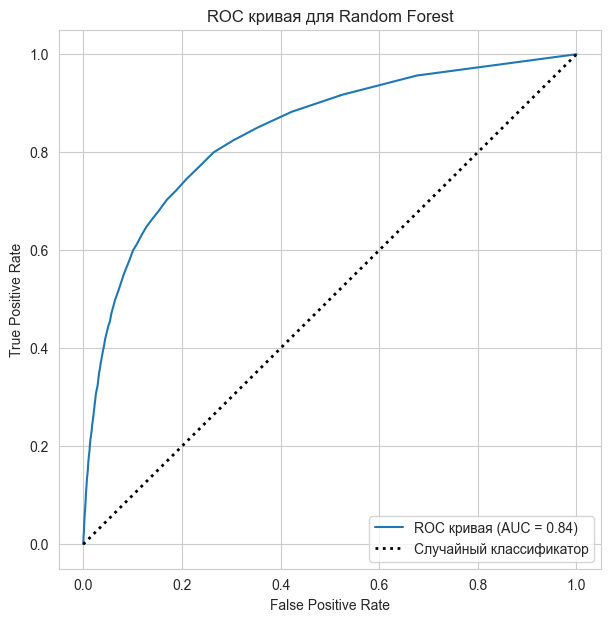

In [63]:
# 26. TODO
test_probabilities_rf = random_forest_model.predict_proba(test_points)[:, 1]
fpr, tpr, thresholds = roc_curve(test_values, test_probabilities_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Случайный классификатор')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая для Random Forest')
plt.legend(loc="lower right")
plt.show()